In [1]:
from pyiron import Project, ase_to_pyiron
import matplotlib.pyplot as plt
import numpy as np
from pyiron import Project
from ase.io import read, write
from pyiron import ase_to_pyiron
import ase
import os
import time
from pyiron import Project
from pyiron import ase_to_pyiron, pyiron_to_ase
import sys  
sys.path.insert(0, '/nfshome/deshmukh/vaibhav/scripts')
import analysis_msd as ms
from scipy.optimize import curve_fit
from pyiron import Project
from pyiron import ase_to_pyiron, pyiron_to_ase
import shutil
import glob
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np 
import scipy.constants as const
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np 
from ovito.io import *
from ovito.modifiers import *
from ovito.pipeline import *
from ovito.data import *
import numpy as np
import os
from ase import neighborlist
from ase.data import covalent_radii 
from ase.calculators.neighborlist import NeighborList
from ase.neighborlist import neighbor_list
from ase.io import read, write 
from ase import Atoms 
from scipy import sparse
import numpy as np 
from ase.io.pov import get_bondpairs
from ovito.io import import_file
from ovito.io.ase import ovito_to_ase  

/nfshome/deshmukh/.local/lib/python3.9/site-packages/ase/calculators/neighborlist.py:5: UserWarning: Moved to ase.neighborlist
  warnings.warn('Moved to ase.neighborlist')


In [2]:
# Create an OVITO data pipeline from an external file:
pipeline_2 = import_file("/nfshome/deshmukh/vaibhav/frank_jÜlich/lmp_6_1_6/large/simu/simu_2/623/dump_nvt_prod.out")

In [3]:
# Ovito RDF analysis GB and grain 
def setup_particle_types(frame, data):
    types = data.particles_.particle_types_
    types.type_by_id_(1).name = "O"
    types.type_by_id_(2).name = "Na"
    types.type_by_id_(4).name = "Si"
    types.type_by_id_(5).name = "P"  
pipeline_2.modifiers.append(setup_particle_types)

In [4]:
# Insert the RDF calculation modifier into the pipeline:
pipeline_2.modifiers.append(CoordinationAnalysisModifier(cutoff = 8.0, number_of_bins = 200))
#pipeline_2.modifiers.append(CoordinationAnalysisModifier(cutoff = 8.0, number_of_bins = 200, partial = True))


In [5]:

# Insert the time-averaging modifier into the pipeline, which accumulates
# the instantaneous DataTable produced by the previous modifier and computes a mean histogram.
pipeline_2.modifiers.append(TimeAveragingModifier(operate_on='table:coordination-rdf'))


In [6]:
# Data export method 1: Convert to NumPy array and write data to a text file:
total_rdf_crystal = pipeline_2.compute().tables['coordination-rdf[average]'].xy()

In [7]:
## Data export method 2: Use OVITO's own export function for DataTable objects:
export_file(pipeline_2, "lmp_6_1_6_623k_total_rdf_2.txt", "txt/table", key="coordination-rdf[average]")

In [8]:
node = pipeline_2

In [9]:
import numpy as np
from ovito.io import import_file
import matplotlib.pyplot as plt

/tmp/ipykernel_766828/2614901112.py:49: RuntimeWarning: invalid value encountered in true_divide
  hove_correlation_self /= (len(particle_positions) * (len(particle_positions) - 1))


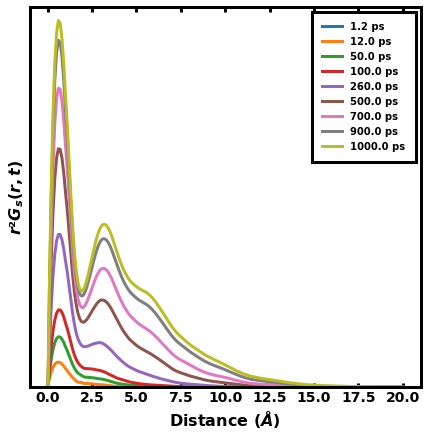

In [16]:
# Load the trajectory
#node = import_file("trajectory.dump")

# Define the time step between two frames
dt = 1.0 # in picoseconds

# Define the number of bins for the correlation function
num_bins = 200

# Define the range of distances to consider
max_distance = 20 # in angstroms
min_distance = 0

# Define the particle type to compute correlation function for
particle_type = 2

# Loop over four different time ranges
#for i, time_range in enumerate([(0, 1000),(1000, 1500), (1500, 2000), (2000, 2700), (2700, 2800),(2800, 2900),(2900, 3000)]):
#:#,(0,for i, time_range in enumerate([(0,100),(0,1000),(0,2000),(0,3000), (0,4000), (0,5000), (0,6000), (0,10000), (0,20000)])40000)]):
for i, time_range in enumerate([(0,12),(0,120),(0,500),(0,1000), (0,2600), (0,5000), (0,7000), (0,9000), (0,10000)]):
    # Create a list to store the particle positions at different time frames
    particle_positions = []

    hove_correlation_self = np.zeros((num_bins,))

    # Loop over time frames in the current time range
    for j in range(time_range[0], time_range[1] + 1, int(dt*100)):

        # Load the particle positions for the current frame
        data = node.compute(frame=j)
        positions = np.array(data.particles['Position'][data.particles['Particle Type'] == particle_type])
        particle_positions.append(positions)

        # Compute the van Hove correlation function for the current frame
        for k, pos1 in enumerate(particle_positions):
            for l, pos2 in enumerate(particle_positions):
                if k >= l:
                    continue
                dr = pos2 - pos1
                d = np.linalg.norm(dr, axis=1) # Magnitude of dr vector

                # Compute the count of particles within each distance bin
                distance_bins = np.linspace(min_distance, max_distance, num_bins+1)
                counts, _ = np.histogram(d, bins=distance_bins)
                
                # Add the counts to the self-correlation function
                hove_correlation_self += counts

    hove_correlation_self /= (len(particle_positions) * (len(particle_positions) - 1))

    # Smooth the self-correlation function using a Savitzky-Golay filter
    from scipy.signal import savgol_filter
    smoothed_hove_correlation_self = savgol_filter(hove_correlation_self, window_length=21, polyorder=3)

    # Create an array of distances corresponding to the center of each bin
    distance_bins = np.linspace(min_distance, max_distance, num_bins)

    # Plot the smoothed self-correlation function for the current time range
    plt.plot(distance_bins, smoothed_hove_correlation_self, label=f"{time_range[1]*100*1/1000} ps",linewidth=3)

# Add legend and labels to the plot
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
#plt.xlim([0, 15])
plt.ylim([0, 350])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
plt.tick_params(width=3, length=4.5)
plt.legend()
#plt.xlim([0,15])
#plt.ylim([0,430])
plt.yticks([])
plt.xlabel(r"Distance ($\AA$)",fontsize=16, weight="bold")
plt.ylabel(r"$r²G_s(r,t)$",fontsize=16, weight="bold")
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black",prop={'size':10},loc="best")
plt.savefig('6_1_6_self_von_hove_corelation.png', bbox_inches='tight', dpi=600, transparent=False)
# Show the plot
plt.show()

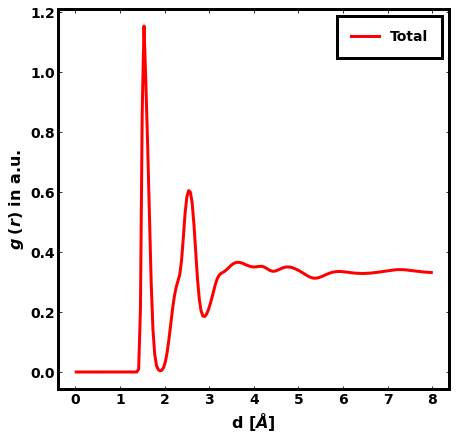

In [11]:
data = np.loadtxt('lmp_6_1_6_623k_partial_rdf_2.txt')
data_1 = np.loadtxt('lmp_6_1_6_623k_total_rdf_2.txt')
#data_2 = np.loadtxt('GB_rdf_08_grain_big_total.txt')
#data_3 = np.loadtxt('GB_rdf_08_gb_big_total.txt')
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
#plt.xlim([0, 6.0])
#plt.ylim([0, 5])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
#x = data[:, 0]
#y = data[:, 1]
x_1 = data_1[:, 0]
y_1 = data_1[:, 1]
#x_2 = data_2[:, 0]
#y_2 = data_2[:, 1]
#y_3 = data_3[:, 1]/12   # Divide by 10 to compare with 
plt.plot(x_1, y_1/3,label="Total", color = 'red', linestyle='-', linewidth=3)
#plt.plot(x, y_2,label="Grain", color = 'royalblue', linestyle='-', linewidth=3, alpha=0.75)
#plt.plot(x, y_3,label="Grain Boundary", color = 'darkorange', linestyle='-', linewidth=3,alpha=0.75)
#plt.plot(x, y,label="Amorphous", color='green', linewidth=3, linestyle='-',alpha=0.75)
#plt.axhline(y=1, linestyle='--', color='black')
plt.xlabel(r"d [$\AA$]", fontsize=16)
plt.ylabel("$g_ (r)$ in a.u.", fontsize=16)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black")
#plt.savefig("rdf_08_big_total.png", bbox_inches='tight', dpi=600, transparent=False)
plt.show()

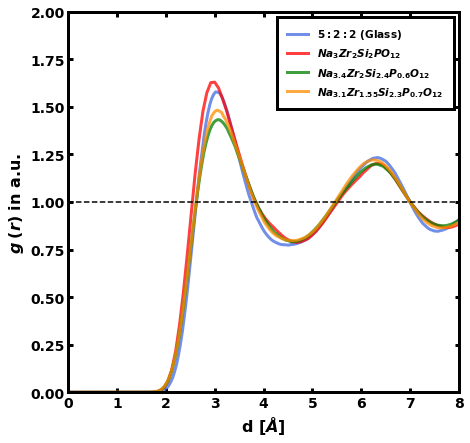

In [12]:
# Na-Na
data = np.loadtxt('lmp_6_1_6_623k_partial_rdf_2.txt')                                                             # Sodium phosphosilicate glass
data_1 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/amorphous_rdf_partial.txt')                     # Nasicon glass, x = 2  
data_2 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_1_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4
data_3 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_2_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4, reduced Zr 
#data_5 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/crystal_rdf_partial.txt')
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlim([0, 8.0])
plt.ylim([0, 2])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
plt.tick_params(width=3, length=4.5)
x = data[:, 0]
y = data[:, 5]
x_1 = data_1[:, 0]
y_1 = data_1[:, 6]
x_2 = data_2[:, 0]
y_2 = data_2[:, 6]#[::2]
x_3 = data_2[:, 0]
y_3 = data_3[:, 6]#[::2]

plt.plot(x, y,label="$5:2:2$ (Glass)", color='royalblue', linewidth=3, linestyle='-',alpha=0.75)
plt.plot(x_1, y_1,label="$Na_{3}Zr_{2}Si_{2}PO_{12}$", color = 'red', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_2, y_2,label="$Na_{3.4}Zr_{2}Si_{2.4}P_{0.6}O_{12}$", color = 'green', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_3, y_3,label="$Na_{3.1}Zr_{1.55}Si_{2.3}P_{0.7}O_{12}$", color = 'darkorange', linestyle='-', linewidth=3, alpha=0.75)

plt.axhline(y=1, linestyle='--', color='black')
plt.xlabel(r"d [$\AA$]", fontsize=16)
plt.ylabel("$g_ (r)$ in a.u.", fontsize=16)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black", fontsize=10.5)
#plt.savefig("rdf_3_2_3_partial_na_na.png", bbox_inches='tight', dpi=600, transparent=False)
plt.show()

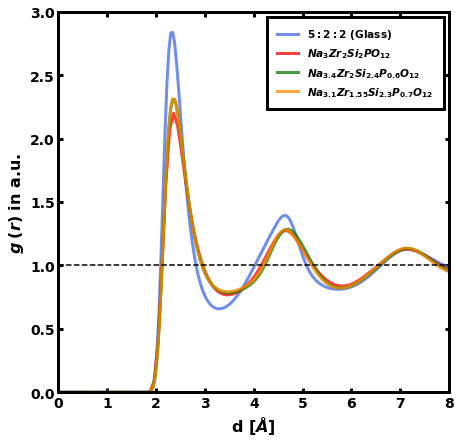

In [13]:
# Na-O  
data = np.loadtxt('lmp_6_1_6_623k_partial_rdf_2.txt')                                                             # Sodium phosphosilicate glass
data_1 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/amorphous_rdf_partial.txt')                     # Nasicon glass, x = 2
data_2 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_1_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4
data_3 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_2_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4, reduced Zr
#data_5 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/crystal_rdf_partial.txt')
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlim([0, 8.0])
plt.ylim([0, 3.0])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
plt.tick_params(width=3, length=4.5)
x = data[:, 0]
y = data[:, 2]
x_1 = data_1[:, 0]
y_1 = data_1[:, 2]
x_2 = data_2[:, 0]
y_2 = data_2[:, 2]#[::2]
x_3 = data_2[:, 0]
y_3 = data_3[:, 2]#[::2]

plt.plot(x, y,label="$5:2:2$ (Glass)", color='royalblue', linewidth=3, linestyle='-',alpha=0.75)
plt.plot(x_1, y_1,label="$Na_{3}Zr_{2}Si_{2}PO_{12}$", color = 'red', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_2, y_2,label="$Na_{3.4}Zr_{2}Si_{2.4}P_{0.6}O_{12}$", color = 'green', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_3, y_3,label="$Na_{3.1}Zr_{1.55}Si_{2.3}P_{0.7}O_{12}$", color = 'darkorange', linestyle='-', linewidth=3, alpha=0.75)

plt.axhline(y=1, linestyle='--', color='black')
plt.xlabel(r"d [$\AA$]", fontsize=16)
plt.ylabel("$g_ (r)$ in a.u.", fontsize=16)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black", fontsize=10.5)
plt.savefig("rdf_6_1_6_partial_na_o.png", bbox_inches='tight', dpi=600, transparent=False)
plt.show()

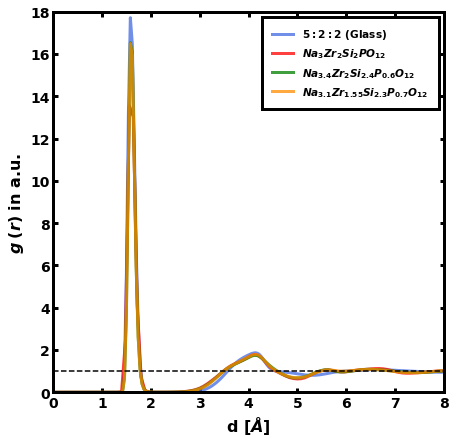

In [14]:
# Si-O
data = np.loadtxt('lmp_6_1_6_623k_partial_rdf_2.txt')                                                             # Sodium phosphosilicate glass
data_1 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/amorphous_rdf_partial.txt')                     # Nasicon glass, x = 2
data_2 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_1_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4
data_3 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_2_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4, reduced Zr
#data_5 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/crystal_rdf_partial.txt')
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlim([0, 8.0])
plt.ylim([0, 18])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
plt.tick_params(width=3, length=4.5)
x = data[:, 0]
y = data[:, 3]
x_1 = data_1[:, 0]
y_1 = data_1[:, 4]
x_2 = data_2[:, 0]
y_2 = data_2[:, 4]#[::2]
x_3 = data_2[:, 0]
y_3 = data_3[:, 4]#[::2]

plt.plot(x, y,label="$5:2:2$ (Glass)", color='royalblue', linewidth=3, linestyle='-',alpha=0.75)
plt.plot(x_1, y_1,label="$Na_{3}Zr_{2}Si_{2}PO_{12}$", color = 'red', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_2, y_2,label="$Na_{3.4}Zr_{2}Si_{2.4}P_{0.6}O_{12}$", color = 'green', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_3, y_3,label="$Na_{3.1}Zr_{1.55}Si_{2.3}P_{0.7}O_{12}$", color = 'darkorange', linestyle='-', linewidth=3, alpha=0.75)

plt.axhline(y=1, linestyle='--', color='black')
plt.xlabel(r"d [$\AA$]", fontsize=16)
plt.ylabel("$g_ (r)$ in a.u.", fontsize=16)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black", fontsize=10.5)
#plt.savefig("rdf_5_2_2_partial_si_o.png", bbox_inches='tight', dpi=600, transparent=False)
plt.show()

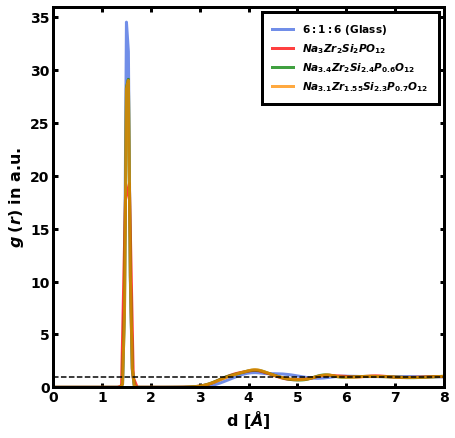

In [15]:
# P-O
data = np.loadtxt('lmp_6_1_6_623k_partial_rdf_2.txt')                                                             # Sodium phosphosilicate glass
data_1 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/amorphous_rdf_partial.txt')                     # Nasicon glass, x = 2
data_2 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_1_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4
data_3 = np.loadtxt('/nfshome/deshmukh/vaibhav/HeNa_frahunhofer/rdf_vonhove/hena_2_big_glass_623k_partial.txt')   # Nasicon glass, x = 2.4, reduced Zr
#data_5 = np.loadtxt('/nfshome/deshmukh/vaibhav/schulze_project/gb/crystal_rdf_partial.txt')
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams.update({'font.size': 14})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlim([0, 8.0])
plt.ylim([0, 36])
plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.rcParams["axes.linewidth"] = 3
plt.rcParams["patch.linewidth"] = 3
plt.tick_params(axis="y",direction="in")
plt.tick_params(axis="x",direction="in")
plt.tick_params(width=3, length=4.5)
x = data[:, 0]
y = data[:, 4]
x_1 = data_1[:, 0]
y_1 = data_1[:, 5]
x_2 = data_2[:, 0]
y_2 = data_2[:, 5]#[::2]
x_3 = data_2[:, 0]
y_3 = data_3[:, 5]#[::2]

plt.plot(x, y,label="$6:1:6$ (Glass)", color='royalblue', linewidth=3, linestyle='-',alpha=0.75)
plt.plot(x_1, y_1,label="$Na_{3}Zr_{2}Si_{2}PO_{12}$", color = 'red', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_2, y_2,label="$Na_{3.4}Zr_{2}Si_{2.4}P_{0.6}O_{12}$", color = 'green', linestyle='-', linewidth=3, alpha=0.75)
plt.plot(x_3, y_3,label="$Na_{3.1}Zr_{1.55}Si_{2.3}P_{0.7}O_{12}$", color = 'darkorange', linestyle='-', linewidth=3, alpha=0.75)

plt.axhline(y=1, linestyle='--', color='black')
plt.xlabel(r"d [$\AA$]", fontsize=16)
plt.ylabel("$g_ (r)$ in a.u.", fontsize=16)
plt.legend(fancybox=False, framealpha=1, shadow=False, borderpad=1, frameon=True, edgecolor="black", fontsize=10.5)
plt.savefig("rdf_6_1_6_partial_p_o.png", bbox_inches='tight', dpi=600, transparent=False)
plt.show()